### Import libraries

In [177]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import string
import random
from tqdm import tqdm

### Import keras libraries

In [2]:
import tensorflow
from keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from nltk.translate.bleu_score import sentence_bleu

### Import train,test,val image names from given datafiles  

In [3]:
train_image_names = open('./flickr-8k/Flickr8k_text-20220427T180132Z-001/Flickr8k_text/Flickr_8k.trainImages.txt','r').read().splitlines()
val_image_names = open('./flickr-8k/Flickr8k_text-20220427T180132Z-001/Flickr8k_text/Flickr_8k.valImages.txt','r').read().splitlines()
test_image_names = open('./flickr-8k/Flickr8k_text-20220427T180132Z-001/Flickr8k_text/Flickr_8k.testImages.txt','r').read().splitlines()
images_path = './flickr-8k/Flicker8k_Images-20220427T175615Z-001/Flicker8k_Images/'

### Import lemmatized text decriptions from datafiles

In [4]:
lemma_desc_list  = open('./flickr-8k/Flickr8k_text-20220427T180132Z-001/Flickr8k_text/Flickr8k.token.txt','r').read().splitlines()

### Cleaning the text descriptions

In [5]:
table = str.maketrans('', '', string.punctuation)
def preprocess_text(text):
    text = text.lower()
    text = text.split()
    text = [w.translate(table) for w in text]

    # remove tokens with numbers in them
    text = [word for word in text if word.isalpha()]
    # store as string
    
    return ' '.join(text)

#### Store the descriptions in a dictionary

In [6]:
lemmatized_text_desc = {}
for i in lemma_desc_list:
    image_name = i.split('\t')[0]
    image_name = image_name.split('#')[0]
    text = i.split('\t')[1]
    text = preprocess_text(text)
    if image_name in lemmatized_text_desc:
        lemmatized_text_desc[image_name].append(text)
    else:
        lemmatized_text_desc[image_name] = [text]

In [7]:
lemmatized_text_desc[train_image_names[0]]

['a black dog is running after a white dog in the snow',
 'black dog chasing brown dog through snow',
 'two dogs chase each other across the snowy ground',
 'two dogs play together in the snow',
 'two dogs running through a low lying body of water']

#### Sample Image with its text descriptors from training data 

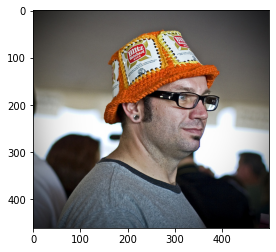

''a man in an orange hat starring at something''
''a man wears an orange hat and glasses''
''a man with gauges and glasses is wearing a blitz hat''
''a man with glasses is wearing a beer can crocheted hat''
''the man with pierced ears is wearing glasses and an orange hat''


In [8]:
image_name_list = list(lemmatized_text_desc.keys())
image_name = image_name_list[4]
x = plt.imread(images_path+image_name)
plt.imshow(x)
plt.show()
for i in lemmatized_text_desc[image_name]:
    print("''"+i+"''")

#### Append startseq and endseq to each sentence to distinguish the end of the sentence

In [9]:
for image_name in image_name_list:
    for i in range(len(lemmatized_text_desc[image_name])):
        lemmatized_text_desc[image_name][i] = 'startseq ' + lemmatized_text_desc[image_name][i] + ' endseq'

#### Split descriptors into train,val and test descriptors  

In [10]:
train_text = {}
val_text = {}
test_text = {}
for i in train_image_names:
    train_text[i] = lemmatized_text_desc[i]
for i in val_image_names:
    val_text[i] = lemmatized_text_desc[i]
for i in test_image_names:
    test_text[i] = lemmatized_text_desc[i]

#### Check the maximum length before training

In [11]:
max_length = 0
for filename,texts in lemmatized_text_desc.items():
    for i in texts:
        if(max_length < len(i.split())):
            max_length = len(i.split())
            max_string = i
            max_list = i.split()

In [12]:
max_length

37

#### Delete the words which are not repeated for more than a certain number of times. (No usefule information from these words to train) 

In [14]:
word_counts = {}
nsents = 0
for key,values in train_text.items():
    for i in values:
        nsents += 1
        for w in i.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1
vocabulary = [w for w in word_counts if word_counts[w] >= 10]
print(len(vocabulary))

1654


#### Import all the word embeddings from GloVe 6b

In [15]:
embeddings_index = {} 
glove_file = open(os.path.join('./glove.6B.200d.txt'), encoding="utf-8")
for line in glove_file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

#### Assign indices to the words and vice-versa 

In [16]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocabulary:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

#### Convert the words into corresponding word embedding vectors

In [17]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### CNN model (ResNet50) for feature extraction from images

In [18]:
resnet_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
resnet_model.summary()

2022-05-08 15:26:39.905313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

2022-05-08 15:26:40.812263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 15:26:40.812816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 15:26:40.829998: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-08 15:26:40.831879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [19]:
def img_preprocess(img_path):
    im = cv2.imread(images_path  + img_path)   
    im_res = cv2.resize(im,(224,224))
    im_res = np.expand_dims(im_res, axis=0)
    return im_res

#### Predict the feature vectors for each training image 

In [215]:
# train_data = {}
# ctr=0
# for ix in train_image_names:
#     if ix == "":
#         continue
#     ctr+=1
#     if ctr%500==0:
#         print(ctr)
#     path = ix
#     img = img_preprocess(path)
#     pred = resnet_model.predict(img).reshape(2048)
#     train_data[ix] = pred

#### Store and load the image feature vectors

In [26]:
filename = 'cnn_train_features.pickle'
file = open(filename, 'rb')
trainImg_features = pkl.load(file)

In [27]:
# filename = 'cnn_train_features.pickle'
# file = open(filename, 'wb')
# pkl.dump(train_data,file)

### CNN model (ResNet50) for feature extraction from images

In [116]:
# from time import time
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.inception_v3 import preprocess_input

In [117]:
# inc_model = InceptionV3(weights='imagenet')
# model_new = Model(inc_model.input, inc_model.layers[-2].output)

In [118]:
# # Function to encode a given image into a vector of size (2048, )
# def encode(image):
#     image = img_preprocess(image) # preprocess the image
#     fea_vec = model_new.predict(image) # Get the encoding vector for the image
#     fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
#     return fea_vec

In [120]:
# start = time()
# encoding_train = {}
# x = 0
# for img in train_image_names:
#     encoding_train[img] = encode(img)
#     if x %100 == 0:
#         print(x)
#     x+=1
# print("Time taken in seconds =", time()-start)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
Time taken in seconds = 751.97980260849


### Sequential LSTM model to predict captions

In [34]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 37, 200)      331000      ['input_7[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_6[0][0]']                
                                                                                            

#### Setting the embedding layer weights to the weights we predicted from the word embeddings

In [35]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

#### Data loader

In [37]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

### Train the CNN-LSTM Network

In [38]:
epochs = 15
batch_size = 3
steps = len(train_text)//batch_size

generator = data_generator(train_text, trainImg_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/15
2000/2000 [==============================] - 174s 85ms/step - loss: 3.7167
Epoch 2/15
2000/2000 [==============================] - 260s 130ms/step - loss: 3.0520
Epoch 3/15
2000/2000 [==============================] - 282s 141ms/step - loss: 2.8539
Epoch 4/15
2000/2000 [==============================] - 305s 152ms/step - loss: 2.7383
Epoch 5/15
2000/2000 [==============================] - 279s 140ms/step - loss: 2.6565
Epoch 6/15
2000/2000 [==============================] - 260s 130ms/step - loss: 2.5962
Epoch 7/15
2000/2000 [==============================] - 260s 130ms/step - loss: 2.5464
Epoch 8/15
2000/2000 [==============================] - 291s 145ms/step - loss: 2.5074
Epoch 9/15
2000/2000 [==============================] - 291s 145ms/step - loss: 2.4711
Epoch 10/15
2000/2000 [==============================] - 250s 125ms/step - loss: 2.4409
Epoch 11/15
2000/2000 [==============================] - 260s 130ms/step - loss: 2.4198
Epoch 12/15
2000/2000 [===================

In [ ]:
# epochs = 15
# batch_size = 4
# steps = len(train_text)//batch_size

# generator = data_generator(train_text, trainImg_features, wordtoix, max_length, batch_size)
# model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

In [164]:
#Removes start and end seq from test captions
def remove_seq(test_captions):
    for i in range(len(test_captions)):
        text = test_captions[i]
        word_list = text.split()
        word_list = word_list[1:-1]
        test_captions[i] = ' '.join(word_list)
    return test_captions

In [39]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([photo,sequence], verbose=0)
        
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Inferencing few captions on the test data

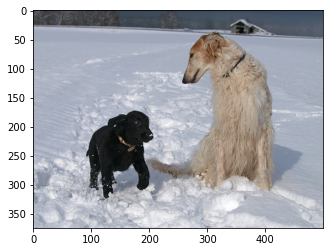

two dogs are running through the snow


In [272]:
image_name = test_image_names[91]
img = img_preprocess(image_name)
pred = resnet_model.predict(img).reshape(1,2048)

x = plt.imread(images_path+image_name)
plt.imshow(x)
plt.show()

prediction = greedySearch(pred)
print(prediction)

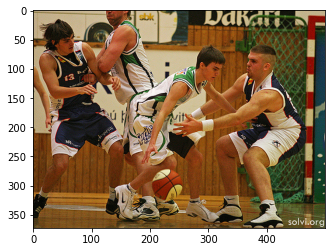

a basketball player in a white uniform is being thrown by the opposing team


In [265]:
image_name = test_image_names[9]
img = img_preprocess(image_name)
pred = resnet_model.predict(img).reshape(1,2048)

x = plt.imread(images_path+image_name)
plt.imshow(x)
plt.show()

prediction = greedySearch(pred)
print(prediction)

### Model Evaluation with BLEU scores 

In [226]:
def evaluate_model_greedy(image_list):
    scores = []
    predictions = []
    image_list = random.sample(image_list, 500)
    for image_name in tqdm(image_list):    
        img = img_preprocess(image_name)
        pred = resnet_model.predict(img).reshape(1,2048)
        
        prediction = greedySearch(pred)
        predictions.append(prediction)
        
        reference = test_text[image_name].copy()
        reference = remove_seq(reference)

        score = sentence_bleu(reference, prediction)
        scores.append(score)
    return scores,predictions

In [227]:
g_scores,g_predictions = evaluate_model_greedy(test_image_names)

 10%|████▎                                     | 51/500 [00:45<07:30,  1.00s/it]/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|█████████████████████████████████████████| 500/500 [07:21<00:00,  1.13it/s]


### Average Bleu scores with greedy search  

In [228]:
np.mean(g_scores)

0.5556862696275021

In [229]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [230]:
def evaluate_model_beam(image_list):
    scores = []
    predictions = []
    for image_name in tqdm(image_list[:200]):    
        img = img_preprocess(image_name)
        pred = resnet_model.predict(img).reshape(1,2048)
        
        prediction = beam_search_predictions(pred, beam_index = 3)
        predictions.append(prediction)
        
        reference = test_text[image_name].copy()
        reference = remove_seq(reference)

        score = sentence_bleu(reference, prediction)
        scores.append(score)
    return scores,predictions

In [231]:
b_scores,b_predictions = evaluate_model_beam(test_image_names)

100%|█████████████████████████████████████████| 200/200 [19:06<00:00,  5.73s/it]


### Average Bleu Scores with Beam Search (k = 3)

In [232]:
np.mean(b_scores)

0.5631185353150369

### Average Corpus Bleu Scores with Beam Search (k = 3)

In [239]:
from nltk.translate.bleu_score import corpus_bleu

In [253]:
references =[]
for image_name in tqdm(test_image_names[:200]):    
    reference = test_text[image_name].copy()
    reference = remove_seq(reference)
    word_list = []    
    for sen in reference:
        word_list.append(sen.split())
    references.append(word_list)

100%|██████████████████████████████████████| 200/200 [00:00<00:00, 22255.67it/s]


In [254]:
predictions_words = []
for prediction in b_predictions:
    predictions_words.append(prediction.split())

In [255]:
bleu_1 = corpus_bleu(references, predictions_words, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu(references, predictions_words, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, predictions_words, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(references, predictions_words, weights=(0.25, 0.25, 0.25, 0.25))

print("BLEU-1: {:.4f}".format(bleu_1))
print("BLEU-2: {:.4f}".format(bleu_2))
print("BLEU-3: {:.4f}".format(bleu_3))
print("BLEU-4: {:.4f}".format(bleu_4))

BLEU-1: 0.4709
BLEU-2: 0.2920
BLEU-3: 0.1783
BLEU-4: 0.1028


In [33]:
b_scores,b_predictions = evaluate_model_beam(test_image_names)

  0%|          | 0/200 [00:00<?, ?it/s]2022-05-08 13:31:44.004808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-08 13:31:45.480001: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
 61%|██████    | 122/200 [14:31<09:04,  6.99s/it]/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 200/200 [23:42<00:00,  7.11s/it]


### Average Bleu Scores with Beam Search (k = 5)

In [34]:
np.mean(b_scores)

0.5490683872490838

### Average Bleu Scores with Beam Search

In [48]:
references =[]
for image_name in tqdm(test_image_names[:200]):    
    reference = test_text[image_name].copy()
    reference = remove_seq(reference)
    word_list = []    
    for sen in reference:
        word_list.append(sen.split())
    references.append(word_list)   

100%|██████████| 200/200 [00:00<00:00, 15334.82it/s]


In [53]:
predictions_words = []
for prediction in b_predictions:
    predictions_words.append(prediction.split())

In [54]:
from nltk.translate.bleu_score import corpus_bleu
bleu_1 = corpus_bleu(references, predictions_words, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu(references, predictions_words, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(references, predictions_words, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(references, predictions_words, weights=(0.25, 0.25, 0.25, 0.25))

print("BLEU-1: {:.4f}".format(bleu_1))
print("BLEU-2: {:.4f}".format(bleu_2))
print("BLEU-3: {:.4f}".format(bleu_3))
print("BLEU-4: {:.4f}".format(bleu_4))

BLEU-1: 0.5010
BLEU-2: 0.3207
BLEU-3: 0.2076
BLEU-4: 0.1278
